In [ ]:
import pandas as pd
df=pd.read_csv('/kaggle/input/arabic-classification/arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv')
df.head()

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0


In [ ]:
df.shape

(111728, 2)

In [ ]:
data = df.sample(frac=0.5, random_state=42)
data.shape

(55864, 2)

In [ ]:
# Remove rows where the 'text' column is null
data = data.dropna(subset=['text'])


In [ ]:
pip install arabic_reshaper pyarabic camel_tools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for camel-kenlm: filename=camel_kenlm-2024.5.6-cp310-cp310-linux_x86_64.whl size=592944 sha256=c8a77e7db27eebaf7bfc226df0f0a1cf81e50732f666aaa157a462322d80617a
  Stored in directory: /root/.cache/pip/wheels/2b/93/ff/ac84dae74c91ffe3e1c344a71f991946eacc79eada61cb703f
Successfully built camel-kenlm
  Attempting uninstall: tran

In [ ]:
import re
import arabic_reshaper
from pyarabic.araby import strip_tatweel
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import FastText
from nltk.stem.isri import ISRIStemmer
import numpy as np
import pandas as pd

# Step 1: Normalize text
def normalize_text(text):
    text = strip_tatweel(text)                 # Removing tatweel  العـــــربية to العربية
    text = normalize_unicode(text)             #بسم الله الرحمن الرحيم
    text = normalize_alef_ar(text)             #Normalizes Alef characters in Arabic text.
    text = normalize_alef_maksura_ar(text)     #Converts Alef Maksura to Yeh (ى) character.
    text = normalize_teh_marbuta_ar(text)      #Normalizes Teh Marbuta characters (ة) in Arabic text
    return text

# Step 2: Remove diacritics   # التشكيل
def remove_diacritics(text):
    return dediac_ar(text)

# Step 3: Tokenization and cleaning
def tokenize_and_clean(text):
    tokens = word_tokenize(text)
    arabic_tokens = [word for word in tokens if re.match(r'^[\u0600-\u06FF]+$', word)]
    cleaned_tokens = [re.sub(r'[^\w\s]', '', word) for word in arabic_tokens] #  removes ny character that is not a word character (alphanumeric and underscores) or whitespace
    return cleaned_tokens

# Step 4: Stopword removal
def remove_stopwords(tokens):
    nltk_stopwords = set(stopwords.words('arabic'))
    filtered_tokens = [token for token in tokens if token not in nltk_stopwords]
    return filtered_tokens

# Step 5: Stemming
def stem_tokens(tokens):
    stemmer = ISRIStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# all preprocesing without vectorization which i do under specially for lstm model
def preprocess_text(text):
    text = normalize_text(text)
    text = remove_diacritics(text)
    tokens = tokenize_and_clean(text)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)
    return ' '.join(tokens)

# def vectorize_text(texts, method):
#     if method == 'tfidf':
#         vectorizer = TfidfVectorizer()
#         vectors = vectorizer.fit_transform(texts)
#     elif method == 'fasttext':
#         # Tokenize the texts
#         processed_texts = [text.split() for text in texts]

#         # Create and train FastText model
#         model = FastText(vector_size=100, min_count=1, window=5, epochs=10)
#         model.build_vocab(corpus_iterable=processed_texts)
#         model.train(corpus_iterable=processed_texts, epochs=model.epochs, total_examples=model.corpus_count)

#         # Generate vectors by averaging word vectors
#         vectors = np.array([
#             np.mean([model.wv[word] for word in text if word in model.wv] or [np.zeros(model.vector_size)], axis=0)
#             for text in processed_texts
#         ])
#     else:
#         raise ValueError("Invalid vectorization method")
#     return vectors

In [ ]:
# Normalize the 'text' column
data['normalized_text'] = data['text'].apply(normalize_text)

In [ ]:
data['no_diacritics_text'] = data['normalized_text'].apply(remove_diacritics)

In [ ]:
data['cleaned_tokens'] = data['no_diacritics_text'].apply(tokenize_and_clean)

In [ ]:
data['filtered_tokens'] = data['cleaned_tokens'].apply(remove_stopwords)

In [ ]:
data['stemmed_tokens'] = data['filtered_tokens'].apply(stem_tokens)

In [ ]:
data['preprocessed_text'] = data['stemmed_tokens'].apply(lambda tokens: " ".join(tokens))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess your data
X = data['preprocessed_text']
y = data['targe']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) #Converts categorical labels into numerical format
y_categorical = to_categorical(y_encoded) #Converts numerical labels into one-hot encoded format/convert label 1 into [0, 1, 0]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Tokenize the text data // mapping each unique word to an integer index //  "I" → 1  "love" → 2 "machine" → 3
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences // "I love machine learning" → [1, 2, 3, 4]
X_train_seq = tokenizer.texts_to_sequences(X_train) #convert each text into a sequence of integers
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences (using a smaller max_length to speed up training)
max_length = min(max([len(seq) for seq in X_train_seq]), 100)  # Cap at 100 for efficiency
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pad, np.argmax(y_train, axis=1))

# Convert back to categorical
y_train_smote_categorical = to_categorical(y_train_smote)


In [ ]:
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling1D

# Define the LSTM model with additional improvements
# 1-Converts integer sequences into dense vectors of fixed size
# #Parameters: input_dim: Size of the vocabulary (i.e., the number of unique tokens).
# output_dim: Dimensionality of the dense embedding vectors.
# input_length: Length of input sequences.
#2- Applies dropout to entire 1D feature maps to prevent overfitting
#Helps in regularizing the model by reducing reliance on specific features.
#Benefit: Captures semantic meaning of words and reduces dimensionality of input data
def create_improved_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)) # 1
    model.add(SpatialDropout1D(0.3))  # Added spatial dropout for regularization 2
    model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Increased LSTM units
    model.add(GlobalMaxPooling1D())  # Added global max pooling to reduce overfitting
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))  # Added an additional dense layer
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the improved LSTM model
embedding_dim = 100  # Continue with a reasonable embedding dimension
lstm_model = create_improved_lstm_model(vocab_size, embedding_dim, max_length)

# Callbacks: Early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5)

# Train the LSTM model
history = lstm_model.fit(X_train_smote, y_train_smote_categorical, epochs=10, batch_size=32,  # Fine-tuned batch size
                         validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the LSTM model
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Model - Loss: {loss}, Accuracy: {accuracy}')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 215s 96ms/step - accuracy: 0.6043 - loss: 0.9013 - val_accuracy: 0.0186 - val_loss: 3.6414 - learning_rate: 0.0010
Epoch 2/10
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 209s 96ms/step - accuracy: 0.7829 - loss: 0.5361 - val_accuracy: 0.0171 - val_loss: 4.5562 - learning_rate: 0.0010
Epoch 3/10
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 259s 95ms/step - accuracy: 0.8196 - loss: 0.4502 - val_accuracy: 0.0192 - val_loss: 4.8398 - learning_rate: 5.0000e-04
Epoch 4/10
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 262s 95ms/step - accuracy: 0.8403 - loss: 0.4004 - val_accuracy: 0.0211 - val_loss: 5.0879 - learning_rate: 2.5000e-04
340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9109 - loss: 0.2926
LSTM Model - Loss: 0.2879869341850281, Accuracy: 0.9110559225082397


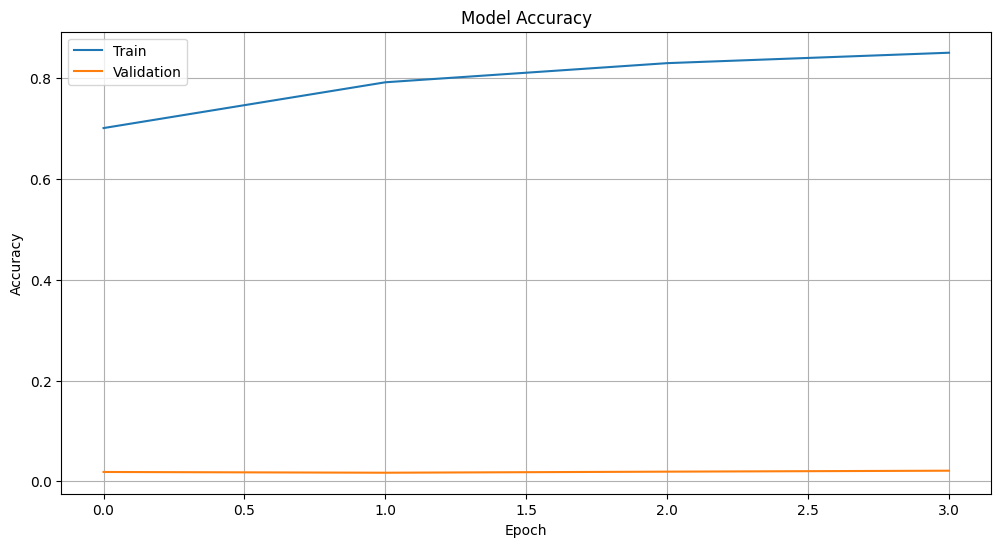

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


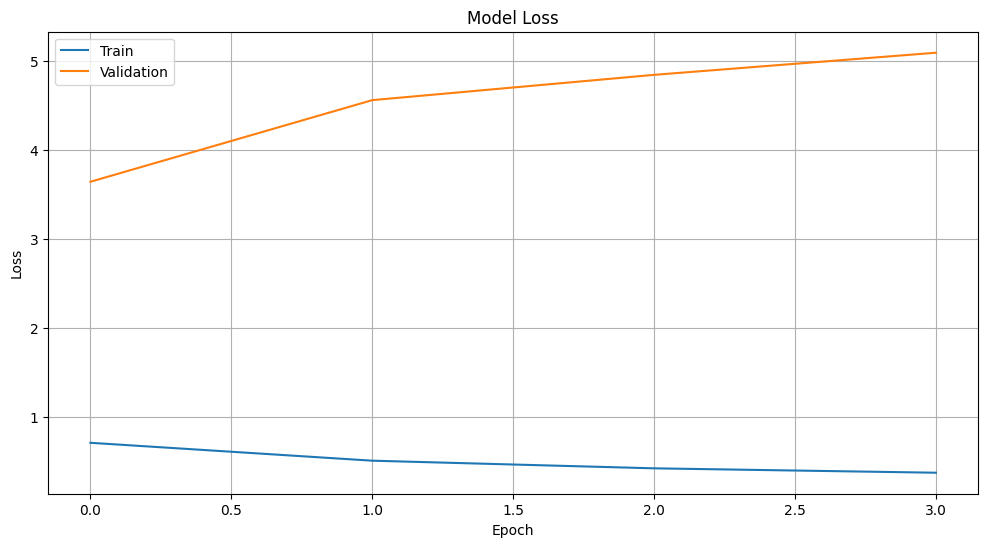

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
# Example synthetic Arabic texts for each class
new_data = [
    {"text": "تقرير ثقافي جديد عن الأدب العربي", "class": 0},  # Culture
    {"text": "مقال عن الأحداث المتنوعة في العالم", "class": 1},  # Diverse
    {"text": "تحليل اقتصادي لأزمة السوق", "class": 2},  # Economy
    {"text": "تقرير سياسي حول الانتخابات", "class": 3},  # Politics
    {"text": "مباراة رياضية مثيرة بين الفرق", "class": 4}   # Sport
]

# Convert to DataFrame
import pandas as pd
test_df = pd.DataFrame(new_data)

# Preprocess text as done with your original training data
X_new_test = test_df['text'].apply(preprocess_text)  # Apply the preprocessing to each row
y_new_test = test_df['class']

# Convert labels to categorical (one-hot encoding)
from tensorflow.keras.utils import to_categorical
y_new_test_categorical = to_categorical(y_new_test, num_classes=5)

# Tokenize and pad sequences
X_new_test_pad = tokenizer.texts_to_sequences(X_new_test)
X_new_test_pad = pad_sequences(X_new_test_pad, maxlen=max_length)

# Evaluate model on new data
new_loss, new_accuracy = lstm_model.evaluate(X_new_test_pad, y_new_test_categorical)
print(f'LSTM Model on New Data - Loss: {new_loss}, Accuracy: {new_accuracy}')

accuracy_percentage = new_accuracy * 100
# Print the results
print(f'LSTM Model on New Data - Loss: {new_loss:.4f}, Accuracy: {accuracy_percentage:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8000 - loss: 0.9173
LSTM Model on New Data - Loss: 0.9173175692558289, Accuracy: 0.800000011920929
LSTM Model on New Data - Loss: 0.9173, Accuracy: 80.00%


In [ ]:
# Step 1: Generate predictions
y_pred = lstm_model.predict(X_new_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class labels

# Step 2: Define the mapping of class labels to class names
class_names = ['Culture', 'Diverse', 'Economy', 'Politics', 'Sport']

# Step 3: Print each text, its true label, and the predicted label
for i in range(len(test_df)):
    text = test_df['text'][i]
    true_label = class_names[y_new_test[i]]
    predicted_label = class_names[y_pred_classes[i]]
    print(f"Text: {text}")
    print(f"True Label: {true_label} | Predicted Label: {predicted_label}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Text: تقرير ثقافي جديد عن الأدب العربي
True Label: Culture | Predicted Label: Culture
--------------------------------------------------
Text: مقال عن الأحداث المتنوعة في العالم
True Label: Diverse | Predicted Label: Culture
--------------------------------------------------
Text: تحليل اقتصادي لأزمة السوق
True Label: Economy | Predicted Label: Economy
--------------------------------------------------
Text: تقرير سياسي حول الانتخابات
True Label: Politics | Predicted Label: Politics
--------------------------------------------------
Text: مباراة رياضية مثيرة بين الفرق
True Label: Sport | Predicted Label: Sport
--------------------------------------------------


340/340 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


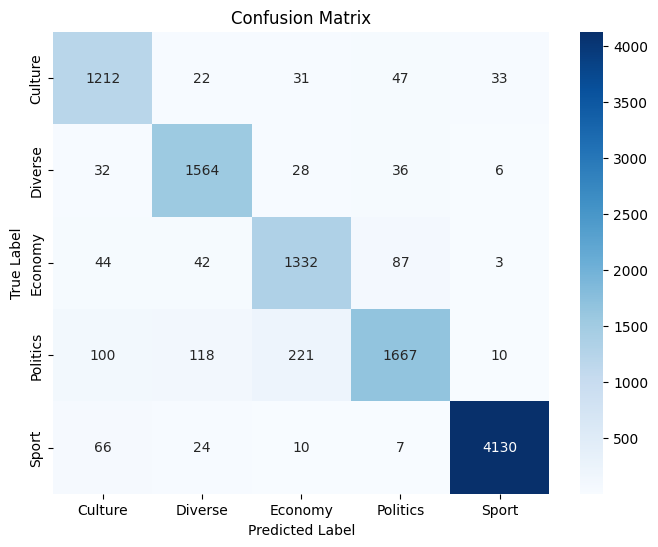

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = lstm_model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Culture', 'Diverse', 'Economy', 'Politics', 'Sport'],
            yticklabels=['Culture', 'Diverse', 'Economy', 'Politics', 'Sport'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
